# 1准备数据

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from pprint import pprint
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from scipy.signal import savgol_filter #滤波
from sklearn.preprocessing import MinMaxScaler  
from torch.utils.data import Dataset,DataLoader
import torchkeras 

In [2]:
from argparse import Namespace
from torch.optim import lr_scheduler
config = Namespace(
    project_name = "twoclass",
    file_path = "../alldata3.csv",
    batch_size = 64,
    dropout_p = 0.1,
    lr = 1e-4,
    optim_type = 'Adam',
    epochs = 100,
    ckpt_path = 'checkpoint',
    num_workers=0
    #name
)

In [3]:

torch.manual_seed(17) #cpu
torch.cuda.manual_seed(17) #gpu
np.random.seed(17) #numpy

In [4]:
class MyDataset(Dataset):
    def __init__(self,filepath):
        self.alldata=pd.read_csv(filepath,header=None)
        self.len=self.alldata.shape[0]
        self.alldata=np.array(self.alldata,dtype='float32')
        self.xdata=torch.from_numpy(self.alldata[:,0:-2])
        self.ydata=torch.from_numpy(self.alldata[:,[-2]])##二分类
    def __getitem__(self,index):
        xx=self.xdata[index]
        lb=savgol_filter(xx, window_length=7, polyorder=2)#Savitzky-Golay 平滑滤波器
        scaler=MinMaxScaler()
        lb=lb.reshape(-1,1)
        lb=scaler.fit_transform(lb)#层归一化
        lb=lb.reshape(1,-1)
        return lb,self.ydata[index]
    def __len__(self):
        return self.len
# 、、、、、、、、、、、、、、、、、、、、

dfdata = MyDataset(config.file_path)

In [5]:
#dataset
# dfdata.ydata=dfdata.ydata.squeeze(1)#
# dfdata.ydata=dfdata.ydata.to(dtype=torch.int64) #使用交叉熵做损失函数时
bb= torch.mean(dfdata.xdata, dim=0)
cc=torch.std(dfdata.xdata, dim=0)
dfdata.xdata= (dfdata.xdata- bb) / cc
dftmp, dftest_raw = train_test_split(dfdata, random_state=40, test_size=0.1)
dftrain_raw, dfval_raw = train_test_split(dftmp, random_state=40, test_size=0.2)



In [6]:
# print("len(dftrain) = ",len(dftrain_raw))
# print("len(dfval) = ",len(dfval_raw))
# print("len(dftest) = ",len(dftest_raw))
# print(dfdata.xdata.shape)
# print(dfdata.ydata.shape)
# print(type(dfdata.ydata[0].item()))

In [6]:
#dataloader
dl_train =DataLoader(dftrain_raw, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
dl_val =DataLoader(dfval_raw, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)
dl_test =DataLoader(dftest_raw, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

In [7]:
for features,labels in dl_val:
    break
print(features.shape)
print(labels.shape)
print(dl_train.__len__())

torch.Size([64, 1, 5000])
torch.Size([64, 1])
300


In [8]:
class SELayer(nn.Module):  
    def __init__(self, channel, reduction=16):  
        super(SELayer, self).__init__()  
        self.avg_pool = nn.AdaptiveAvgPool1d(1)  
        self.fc = nn.Sequential(  
            nn.Linear(channel, channel // reduction, bias=False),  
            nn.ReLU(inplace=True),  
            nn.Linear(channel // reduction, channel, bias=False),  
            nn.Sigmoid()  
        )  
  
    def forward(self, x):  
        b, c, _ = x.size()  
        y = self.avg_pool(x).view(b, c)  
        y = self.fc(y).view(b, c, 1)  
        return x * y.expand_as(x)

class create_net(nn.Module):
    def __init__(self):
        super(create_net,self).__init__()
        self.conv1=nn.Conv1d(in_channels=1,out_channels=8,kernel_size = 5, stride=2, padding=2)
        self.relu=nn.ReLU()
        self.maxpool= nn.MaxPool1d(2)#等价于nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2=nn.Conv1d(in_channels=8,out_channels=16,kernel_size = 5, stride=2, padding=2)
        self.conv3=nn.Conv1d(in_channels=16,out_channels=64,kernel_size = 5, stride=2, padding=2)
#         self.conv4=nn.Conv1d(in_channels=128,out_channels=256,kernel_size = 5, stride=1, padding=2)
#         self.conv5=nn.Conv1d(in_channels=64,out_channels=128,kernel_size = 5, stride=1, padding=2)
        self.fc1= nn.Linear(64*78,1024)
        self.fc2= nn.Linear(1024,256)
        self.fc3= nn.Linear(256,32)
        self.fc4= nn.Linear(32,1)
#         self.fc5= nn.Linear(64,14)
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.conv3(x)
        x=self.relu(x)
        x=self.maxpool(x)
#         x=self.conv4(x)
#         x=self.relu(x)
#         x=self.maxpool(x)
#         x=self.conv5(x)
#         x=self.relu(x)
#         x=self.maxpool(x)
        x=x.view(-1,64*78)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
#         x=F.relu(self.fc4(x))
        x=self.fc4(x)
#         output=F.log_softmax(x,dim=1)
        return x

In [9]:
class AUC(nn.Module):
    'approximate AUC calculation for binary-classification task'
    def __init__(self):
        super().__init__()
        self.tp = nn.Parameter(torch.zeros(10001),requires_grad=False)
        self.fp = nn.Parameter(torch.zeros(10001),requires_grad=False)
        
    def eval_auc(self,tp,fp):
        tp_total = torch.sum(tp)
        fp_total = torch.sum(fp)
        length = len(tp)
        tp_reverse = tp[range(length-1,-1,-1)]
        tp_reverse_cum = torch.cumsum(tp_reverse,dim=0)-tp_reverse/2.0
        fp_reverse = fp[range(length-1,-1,-1)]
        
        auc = torch.sum(torch.true_divide(tp_reverse_cum,tp_total)
                        *torch.true_divide(fp_reverse,fp_total))
        return auc
        
    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        y_pred = (10000*torch.sigmoid(preds)).reshape(-1).type(torch.int)
        y_true = targets.reshape(-1)
        
        tpi = self.tp-self.tp
        fpi = self.fp-self.fp
        assert y_pred.shape == y_true.shape
        for i,label in enumerate(y_true):
            if label>=0.5:
                tpi[y_pred[i]]+=1.0
            else:
                fpi[y_pred[i]]+=1.0
        self.tp+=tpi
        self.fp+=fpi
        return self.eval_auc(tpi,fpi)
          
    def compute(self):
        return self.eval_auc(self.tp,self.fp)
    
    def reset(self):
        self.tp-=self.tp
        self.fp-=self.fp

In [10]:
# windows操作系统
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

# 创建模型

In [13]:
# from torchkeras import summary

# summary(net2,input_data=features);

NameError: name 'net2' is not defined

In [14]:
from torchkeras import KerasModel 
from torchkeras.metrics import Accuracy
from torchkeras.metrics import Precision
from torchkeras.metrics import Recall

from torchkeras.kerascallbacks import WandbCallback
net2 = create_net()
loss_fn = nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(net2.parameters(),lr=config.lr)
metric_dict = {"acc":Accuracy(),"pre":Precision(),"recall":Recall(),"auc":AUC()}
model = KerasModel(net2,
                   loss_fn = loss_fn,
                   metrics_dict= metric_dict,
                   optimizer = optimizer
                  )   


<<<<<< ⚡️ cuda is used >>>>>>


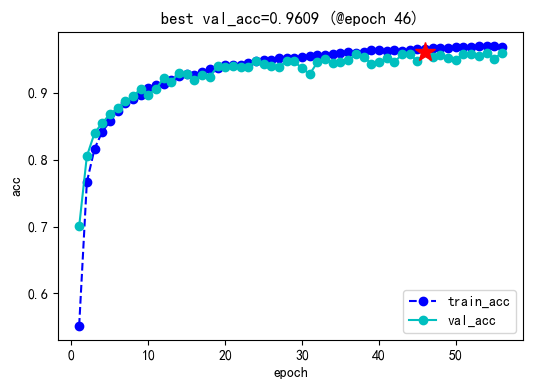

<<<<<< val_acc without improvement in 10 epoch,early stopping >>>>>> 



In [15]:
dfhistory = model.fit(
      train_data=dl_train,
      val_data=dl_val,
      epochs=config.epochs,
      ckpt_path='checkpoint',
      patience=10,
      monitor='val_acc',
      mode='max'
#     ,
#       callbacks = [wandb_cb]
)

# 训练集、测试集评估

# 验证集参数计算

In [ ]:
# #加载网络
# net2 = InceptionModel(
#                 input_size=1,
#                 num_classes=1,
#                 filters=32,
#                 depth=6,
#             )
# net2.load_state_dict(torch.load('checkpoint_two_inception'))

support：当前行的类别在测试数据中的样本总量，如上表就是，在class 0 类别在测试集中总数量为1；<br>
precision：精度=正确预测的个数(TP)/被预测正确的个数(TP+FP)；人话也就是模型预测的结果中有多少是预测正确的<br>
ecall:召回率=正确预测的个数(TP)/预测个数(TP+FN)；人话也就是某个类别测试集中的总量，有多少样本预测正确了；<br>
f1-score:F1 = 2*精度*召回率/(精度+召回率)<br>
micro avg：计算所有数据下的指标值，假设全部数据 5 个样本中有 3 个预测正确，所以 micro avg 为 3/5=0.6<br>
macro avg：每个类别评估指标未加权的平均值，比如准确率的 macro avg，(0.50+0.00+1.00)/3=0.5<br>
weighted avg：加权平均，就是测试集中样本量大的，给他设置的权重大点；比如第一个值的计算方法，(0.50*1 + 0.0*1 + 1.0*3)/5 = 0.70。更好点

In [16]:
from torchkeras import summary

summary(net2,input_data=features)

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv1d-1                               [-1, 8, 2500]                   48
ReLU-2                                 [-1, 8, 2500]                    0
MaxPool1d-3                            [-1, 8, 1250]                    0
Conv1d-4                               [-1, 16, 625]                  656
ReLU-5                                 [-1, 16, 625]                    0
MaxPool1d-6                            [-1, 16, 312]                    0
Conv1d-7                               [-1, 64, 156]                5,184
ReLU-8                                 [-1, 64, 156]                    0
MaxPool1d-9                             [-1, 64, 78]                    0
Linear-10                                 [-1, 1024]            5,112,832
Linear-11                                  [-1, 256]              262,400
Linear-12                            

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nConv1d-1                               [-1, 8, 2500]                   48\nReLU-2                                 [-1, 8, 2500]                    0\nMaxPool1d-3                            [-1, 8, 1250]                    0\nConv1d-4                               [-1, 16, 625]                  656\nReLU-5                                 [-1, 16, 625]                    0\nMaxPool1d-6                            [-1, 16, 312]                    0\nConv1d-7                               [-1, 64, 156]                5,184\nReLU-8                                 [-1, 64, 156]                    0\nMaxPool1d-9                             [-1, 64, 78]                    0\nLinear-10                                 [-1, 1024]            5,112,832\nLinear-11             

In [11]:
#加载网络
net2 = create_net() 
net2.load_state_dict(torch.load('checkpoint'))

<All keys matched successfully>

# 评估矩阵

In [17]:
from tqdm import tqdm 
from sklearn.metrics import classification_report
net2 = net2.cpu()
net2.eval()
preds = []
believer=[]
believer2=[]
ytrue=[]
with torch.no_grad():
    for batch in tqdm(dl_test):
#         preds.append(net(batch))
        inputs,labels=batch
        x=F.sigmoid(net2(inputs))
#         print(x)
        believer2.extend(x.tolist())
        x=torch.where(x > 0.5, torch.ones_like(x),torch.zeros_like(x))
        believer.extend(x.squeeze(1).tolist())
        preds.extend(x.squeeze(1).tolist())
        ytrue.extend(labels.squeeze(1).tolist())
    pprint(len(preds)) 
    pprint(len(ytrue))
#     pprint(preds) 
#     pprint(yhat)
print(classification_report(ytrue,preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 63.34it/s]

4202
4202
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      2039
         1.0       0.98      0.96      0.97      2163

    accuracy                           0.97      4202
   macro avg       0.96      0.97      0.97      4202
weighted avg       0.97      0.97      0.97      4202



In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(ytrue,preds)
# 将混淆矩阵转换为DataFrame
df_cm = pd.DataFrame(cm, index=['True {}'.format(i) for i in range(cm.shape[0])],columns=['Predicted {}'.format(i) for i in range(cm.shape[1])])
pprint(df_cm)
pprint(cm)


        Predicted 0  Predicted 1
True 0         1987           52
True 1           95         2068
array([[1987,   52],
       [  95, 2068]], dtype=int64)


In [ ]:
#2# 使用matplotlib
plt.figure(figsize=(5, 5))
ax=plt.matshow(cm , cmap=plt.cm.Blues,fignum=1, aspect='auto') 
cbar=plt.colorbar(ax, fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=13)
for i in range(len(cm )): 
    for j in range(len(cm )):
        plt.annotate(cm [i,j], xy=(i, j), horizontalalignment='center', verticalalignment='center',fontsize=20)
plt.ylabel('真实值标签',fontsize=15)
plt.xlabel('预测值标签',fontsize=15) 
plt.show()

pr曲线

In [ ]:
b3 = np.array(believer2).ravel().tolist()
b3

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(ytrue, b3)
fig = plt.figure(figsize=(8, 5))
plt.plot(precision, recall, label='label:1')

plt.xlabel('召回率', fontsize=17)
plt.ylabel('精确率', fontsize=17)
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15)

In [ ]:
AP = average_precision_score(ytrue, believer2, average='weighted')
AP

In [ ]:
#PR
import math
result_matrix = [[math.exp(element) for element in row] for row in believer2] 


In [ ]:
# 1二分类标注
# # df = pd.DataFrame()
tempp=np.array(ytrue)
y_test =(tempp==0)
# #2二分类预测置信度
tempr=np.array(believer2)
y_score = tempr[:,0]
print(y_score)
# #3计算ap
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(ytrue, y_score)
AP = average_precision_score(y_test, y_score, average='weighted')
AP

In [23]:
#4计算auc
from sklearn.metrics import roc_curve, auc
# fpr, tpr, threshold = roc_curve(y_test, y_score)

In [19]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']
def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

In [20]:
get_line_arg()

{'color': 'seagreen', 'linestyle': '-', 'linewidth': 1}

In [21]:
classes=[0,1]


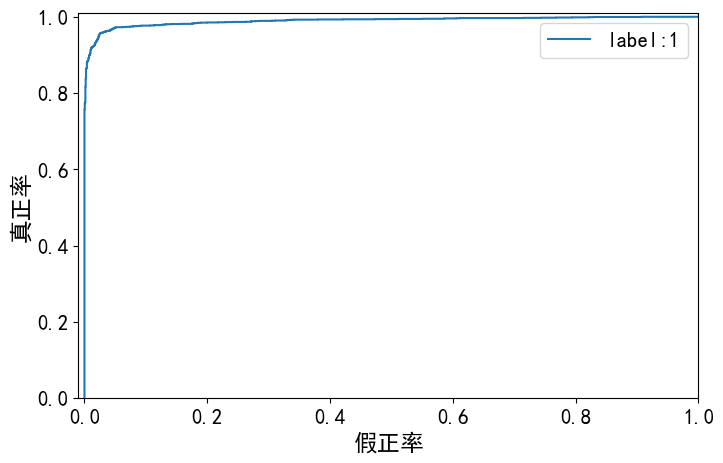

In [24]:
plt.figure(figsize=(8, 5))
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
# plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='随机模型')
# plt.xlabel('False Positive Rate (1 - Specificity)')
# plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('假正率',fontsize=17)
plt.ylabel('真正率',fontsize=17)
plt.tick_params(axis='both', labelsize=15)
plt.rcParams['font.size'] = 22
# plt.grid(True)

auc_list = []
# for each_class in classes:
#     y_test = list((tempp == each_class))
#     y_score = list(tempr[:,each_class])
#     fpr, tpr, threshold = roc_curve(y_test, y_score)
#     plt.plot(fpr, tpr, **get_line_arg(), label='class'+str(each_class))
#     plt.legend()
#     auc_list.append(auc(fpr, tpr))
fpr, tpr, threshold = roc_curve(ytrue,believer2)
plt.plot(fpr, tpr, label='label:1')
plt.legend()
auc_list.append(auc(fpr, tpr))
plt.legend(loc='best', fontsize=15)
# plt.savefig('各类别ROC曲线.pdf'.format(), dpi=120, bbox_inches='tight')
plt.show()

In [25]:
from sklearn.metrics import roc_curve, auc
auc(fpr, tpr)

0.9895684181575324

In [26]:
#保存1
report=classification_report(ytrue,preds,target_names=classes, output_dict=True)
del report['accuracy']
df_report = pd.DataFrame(report).transpose()

df_report

,precision,recall,f1-score,support
0,0.954371,0.974497,0.964329,2039.0
1,0.975472,0.956080,0.965678,2163.0
macro avg,0.964921,0.965288,0.965004,4202.0
weighted avg,0.965233,0.965017,0.965024,4202.0


In [27]:
auc_list

[0.9895684181575324]

In [28]:
# 计算 AUC值 的 宏平均 和 加权平均
macro_avg_auc = np.mean(auc_list)
weighted_avg_auc = sum(auc_list * df_report.iloc[:-2]['support'] / len(ytrue))
auc_list.append(macro_avg_auc)
auc_list.append(weighted_avg_auc)
df_report['AUC'] = auc_list
df_report

ValueError: Length of values (3) does not match length of index (4)

In [29]:
df_report.to_csv('各类别准确率评估指标.csv', index_label='类别')
# df_report.to_csv('各类别准确率评估指标.csv', index=False)

# kappa

In [ ]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(ytrue,preds)
kappa

# t-sne

In [ ]:
#保存模型.pth文件
# torch.save(model,'mycheckpoint/saved1.pth')
#加载模型
#model=torch.load('mycheckpoint/saved1.pth')

In [ ]:
from tqdm import tqdm 
for batch in tqdm(dl_test):
    inputs,labels=batch
    print(inputs.shape)

In [ ]:
#加载网络

for name, module in net2.named_modules():
    print('modules:', name)

In [12]:
net2


create_net(
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(2,), padding=(2,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv3): Conv1d(16, 64, kernel_size=(5,), stride=(2,), padding=(2,))
  (fc1): Linear(in_features=4992, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

In [15]:

#抽取中间层
from torchvision.models.feature_extraction import create_feature_extractor
model_trunc = create_feature_extractor(net2, return_nodes={'fc3': 'semantic_feature'})

In [17]:
a=torch.randn([1,5000])
pred_logits = model_trunc(a) 
pred_logits['semantic_feature'].squeeze().detach().numpy().shape

(32,)

In [18]:
from tqdm import tqdm 
# preds = []
# 抽取层的输出维度
preds =torch.empty((0, 32))
ll=torch.empty(0)
# print(preds.shape)
for batch in tqdm(dl_test):
    inputs,labels=batch
#     print(inputs.shape)
    for a in inputs:
#         print(a.shape)
        a=a.squeeze(1)
#         print(a.shape)
        pred_logits=model_trunc(a)
        tmp=pred_logits['semantic_feature'].detach()
        preds=torch.cat((preds, tmp), dim=0)
    ll=torch.cat((ll,labels), dim=0)
# preds=torch.tensor(preds)
print(preds.shape)
print(ll.shape)
tsne_in=np.array(preds)
ll_in=np.array(ll)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:04<00:00, 10.19it/s]

torch.Size([2660, 32])
torch.Size([2660, 1])


In [19]:
# 降维到二维和三维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=1)
X_tsne_2d = tsne.fit_transform(tsne_in)
print(X_tsne_2d.shape)

(2660, 2)


In [20]:
#二维平面可视化
import seaborn as sns
marker_list = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
class_list = np.array([0,1] ,dtype='float32')
class_list

array([0., 1.], dtype=float32)

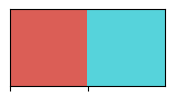

In [21]:
n_class = len(class_list) # 测试集标签类别数
palette = sns.hls_palette(n_class) # 配色方案
sns.palplot(palette)

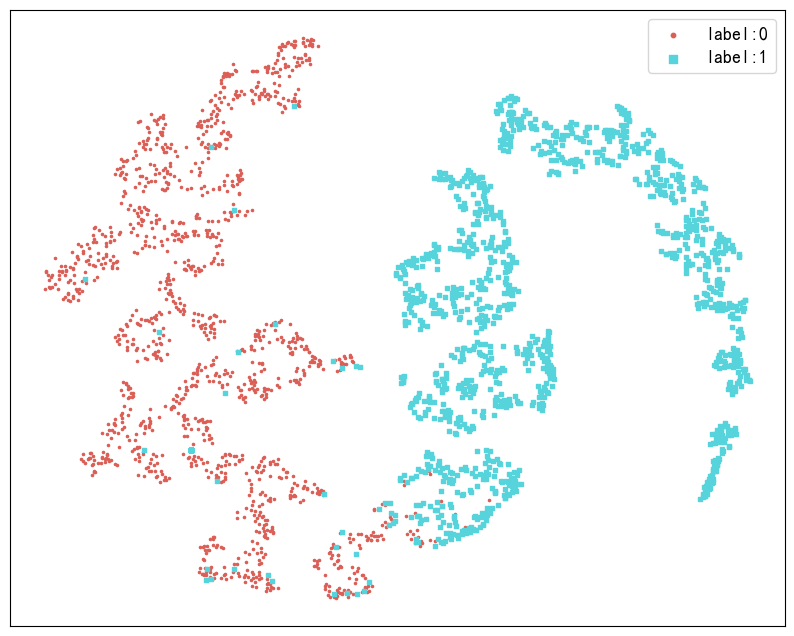

In [28]:
plt.figure(figsize=(10, 8))
for idx, typee in enumerate(class_list): # 遍历每个类别
    # 获取颜色和点型
    color = palette[idx]
    marker = marker_list[idx%len(marker_list)]

    # 找到所有标注类别为当前类别的图像索引号
    indices = np.where(ll_in==typee)
    plt.scatter(X_tsne_2d[indices, 0], X_tsne_2d[indices, 1], color=color, marker=marker, label='label:'+str(int(typee)), s=10)

plt.legend(fontsize=13, markerscale=2, )#2倍原图例大小，右上角
plt.xticks([])
plt.yticks([])
plt.savefig('多维语义特征t-SNE二维降维可视化.jpg', dpi=300) # 保存图像
plt.show()

In [ ]:
#二维交互可视化
import plotly.express as px
df_2d = pd.DataFrame()
df_2d['X'] = list(X_tsne_2d[:, 0].squeeze())
df_2d['Y'] = list(X_tsne_2d[:, 1].squeeze())
df_2d['标注类别名称'] = ll_in
df_2d.to_csv('t-SNE-2D.csv', index=False)

In [ ]:
df_2d

In [ ]:
fig = px.scatter(df_2d, 
                 x='X', 
                 y='Y',
                 color='标注类别名称', 
                 labels='标注类别名称',
                 symbol='标注类别名称', 
                 opacity=0.8,
                 width=1000, 
                 height=600
                )
# 设置排版
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
fig.write_html('语义特征t-SNE二维降维plotly可视化.html')

In [ ]:
#三维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, n_iter=10000)
X_tsne_3d = tsne.fit_transform(tsne_in)
print(X_tsne_3d.shape)

In [ ]:
#3维交互可视化
df_3d = pd.DataFrame()
df_3d['X'] = list(X_tsne_3d[:, 0].squeeze())
df_3d['Y'] = list(X_tsne_3d[:, 1].squeeze())
df_3d['Z'] = list(X_tsne_3d[:, 2].squeeze())
df_3d['标注类别名称'] = ll_in
# df_3d.to_csv('t-SNE-3D.csv', index=False)


In [ ]:
df_3d

In [ ]:
show_feature = '标注类别名称'

In [ ]:

import plotly.express as px
fig = px.scatter_3d(df_3d, 
                    x='X', 
                    y='Y', 
                    z='Z',
                    color='X', 
#                     labels=show_feature,
#                     symbol=show_feature, 
                    opacity=0.6,
                    width=800, 
                    height=580)

# 设置排版
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
fig.write_html('语义特征t-SNE三维降维plotly可视化.html')